# Proyecto
## PlusTI - Detección de fraude
Universidad del Valle de Guatemala<br>
Security Data Science<br>
Pablo Andrés Zamora Vásquez<br>
Carné 21780

## Análisis Exploratorio (EDA)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Cargar el conjunto de datos y mostrar sus tipos:

In [2]:
df = pd.read_csv('./data/dataset_feature_engineering.csv', parse_dates=['dob'])
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 35 columns):
 #   Column                           Dtype         
---  ------                           -----         
 0   cc_num                           int64         
 1   merchant                         object        
 2   category                         object        
 3   amt                              float64       
 4   first                            object        
 5   last                             object        
 6   gender                           object        
 7   street                           object        
 8   city                             object        
 9   state                            object        
 10  zip                              int64         
 11  lat                              float64       
 12  long                             float64       
 13  city_pop                         int64         
 14  job                              o

,cc_num,merchant,category,amt,first,last,gender,street,city,state,...,first_time_at_merchant,dist_between_client_and_merch,trans_month,trans_day,hour,year,times_shopped_at_merchant,times_shopped_at_merchant_year,times_shopped_at_merchant_month,times_shopped_at_merchant_day
0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,...,True,78.773821,1,1,0,2019,5,4,2,1
1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,...,True,30.216618,1,1,0,2019,4,4,1,1
2,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,...,True,108.102912,1,1,0,2019,4,3,1,1
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,...,True,95.685115,1,1,0,2019,1,1,1,1
4,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,...,True,77.702395,1,1,0,2019,6,1,1,1


### Balance de transacciones legítimas y fraudulentas
Revisando el balance entre transacciones legítimas y fraudulentas:

In [14]:
100*df.is_fraud.value_counts(normalize=True)

is_fraud
0    99.478999
1     0.521001
Name: proportion, dtype: float64

### Fecha de transacción

El dataset cuenta con el año, mes y día de la semana en la que se realizó la transacción, pero **no cuenta con el día del mes**.

Añadido a esto, al convertir el campo "unix_time" de cada transacción a un formato de fecha, se obtiene una fecha 7 años antes de lo que indica la columna "year":

In [24]:
# Comparar unix_time y "trans_month", "trans_day", y "year"

# Unix time a datetime
df['unix_time_datetime'] = pd.to_datetime(df['unix_time'], unit='s')
df['unix_time_datetime']

0         2012-01-01 00:00:18
1         2012-01-01 00:00:44
2         2012-01-01 00:00:51
3         2012-01-01 00:01:16
4         2012-01-01 00:03:06
                  ...        
1852389   2013-12-31 23:59:07
1852390   2013-12-31 23:59:09
1852391   2013-12-31 23:59:15
1852392   2013-12-31 23:59:24
1852393   2013-12-31 23:59:34
Name: unix_time_datetime, Length: 1852394, dtype: datetime64[ns]

In [26]:
df[['year', 'trans_month', 'trans_day', 'hour']]

,year,trans_month,trans_day,hour
0,2019,1,1,0
1,2019,1,1,0
2,2019,1,1,0
3,2019,1,1,0
4,2019,1,1,0
...,...,...,...,...
1852389,2020,12,3,23
1852390,2020,12,3,23
1852391,2020,12,3,23
1852392,2020,12,3,23


Por tanto, **se asumirá que el año correcto de cada transacción es el de la columna "year"**; sin embargo, para corregir la falta del día del mes, se usará la fecha unix y se sumarán 7 años.

In [3]:
# 1) Convertir unix_time a datetime
df['date_from_unix'] = pd.to_datetime(df['unix_time'], unit='s', utc=True)

# 2) Desplazarla 7 años para que el año pase de 2012 → 2019
df['date_corrected'] = df['date_from_unix'] + pd.DateOffset(years=7)

# 3) extraer día de mes, mes, año, dow, flag de fin de semana
df['day']        = df['date_corrected'].dt.day
df['month']      = df['date_corrected'].dt.month
df['year']       = df['date_corrected'].dt.year
df['dow']        = df['date_corrected'].dt.dayofweek    # 0=Lun … 6=Dom

df[['unix_time', 'date_from_unix', 'date_corrected', 'day', 'month', 'year', 'dow']]

,unix_time,date_from_unix,date_corrected,day,month,year,dow
0,1325376018,2012-01-01 00:00:18+00:00,2019-01-01 00:00:18+00:00,1,1,2019,1
1,1325376044,2012-01-01 00:00:44+00:00,2019-01-01 00:00:44+00:00,1,1,2019,1
2,1325376051,2012-01-01 00:00:51+00:00,2019-01-01 00:00:51+00:00,1,1,2019,1
3,1325376076,2012-01-01 00:01:16+00:00,2019-01-01 00:01:16+00:00,1,1,2019,1
4,1325376186,2012-01-01 00:03:06+00:00,2019-01-01 00:03:06+00:00,1,1,2019,1
...,...,...,...,...,...,...,...
1852389,1388534347,2013-12-31 23:59:07+00:00,2020-12-31 23:59:07+00:00,31,12,2020,3
1852390,1388534349,2013-12-31 23:59:09+00:00,2020-12-31 23:59:09+00:00,31,12,2020,3
1852391,1388534355,2013-12-31 23:59:15+00:00,2020-12-31 23:59:15+00:00,31,12,2020,3
1852392,1388534364,2013-12-31 23:59:24+00:00,2020-12-31 23:59:24+00:00,31,12,2020,3


In [4]:
# Eliminar información de zona horaria para poder restar fechas
df['transaction_dt'] = df['date_corrected'].dt.tz_convert(None)
df.drop(columns=['date_from_unix', 'date_corrected'], inplace=True)

### Edad
Obtener la edad del cliente que realiza la transacción permitirá visualizar qué grupo de edades es más vulnerable a fraude

In [5]:
df['dob'] = pd.to_datetime(df['dob'])

# Calcular edad en años completos
df['age'] = (df['transaction_dt'] - df['dob']).dt.days // 365
df['age'].head()

0    30
1    40
2    56
3    52
4    32
Name: age, dtype: int64

In [6]:
bins   = [0, 30, 45, 60, 75, np.inf]
labels = ['< 30', '30-45', '46-60', '61-75', '> 75']

df['age_group'] = pd.cut(
    df['age'],
    bins=bins,
    labels=labels,
    right=True,
    include_lowest=True
)

df[['age','age_group']].head(10)

,age,age_group
0,30,< 30
1,40,30-45
2,56,46-60
3,52,46-60
4,32,30-45
5,57,46-60
6,25,< 30
7,71,61-75
8,77,> 75
9,44,30-45


c:\Users\Pablo Zamora\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


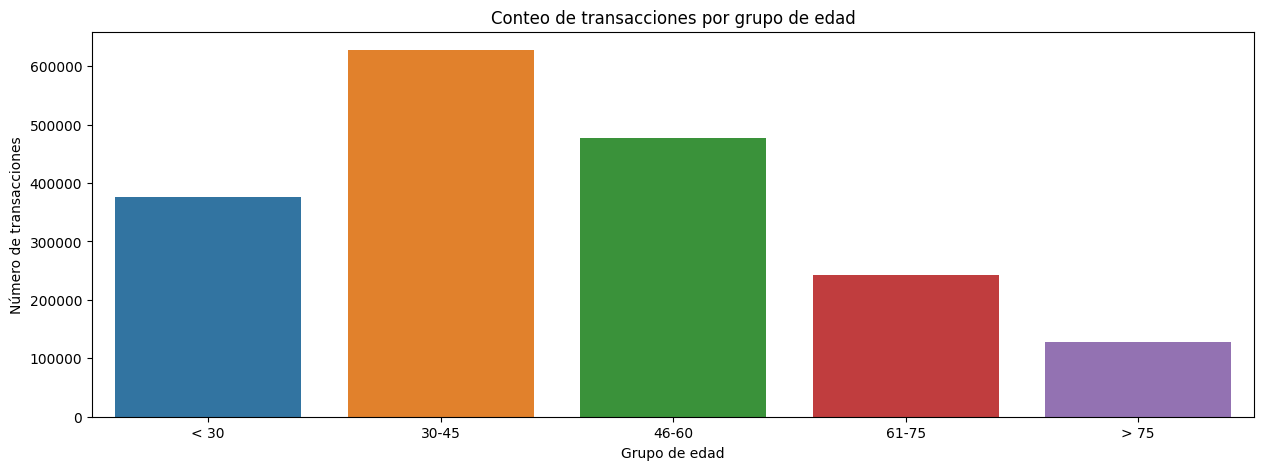

In [41]:
# Graficar el conteo de transacciones por grupo de edad
plt.figure(figsize=(15, 5))
sns.countplot(data=df, x='age_group')
plt.title('Conteo de transacciones por grupo de edad')
plt.xlabel('Grupo de edad')
plt.ylabel('Número de transacciones')
plt.show()

In [42]:
df_age_group = (
    df
    .groupby('age_group')['trans_num']
    .count()
    .reset_index(name='age_count')
)

df_fraud_age_group = (
    df
    .groupby(['age_group','is_fraud'])['trans_num']
    .count()
    .reset_index(name='Transaction count')
)

df_fraud_age_group = df_fraud_age_group.merge(
    df_age_group,
    on='age_group',
    how='inner'
)

df_fraud_age_group['Transaction percentage'] = (
    df_fraud_age_group['Transaction count'] 
    / df_fraud_age_group['age_count'] 
    * 100
)

df_fraud_age_group

C:\Users\Pablo Zamora\AppData\Local\Temp\ipykernel_12248\3993522101.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('age_group')['trans_num']
C:\Users\Pablo Zamora\AppData\Local\Temp\ipykernel_12248\3993522101.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['age_group','is_fraud'])['trans_num']


,age_group,is_fraud,Transaction count,age_count,Transaction percentage
0,< 30,0,374657,376571,99.491729
1,< 30,1,1914,376571,0.508271
2,30-45,0,624933,627471,99.595519
3,30-45,1,2538,627471,0.404481
4,46-60,0,474334,477106,99.418997
5,46-60,1,2772,477106,0.581003
6,61-75,0,241187,242628,99.406087
7,61-75,1,1441,242628,0.593913
8,> 75,0,127632,128618,99.233389
9,> 75,1,986,128618,0.766611


c:\Users\Pablo Zamora\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\Pablo Zamora\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


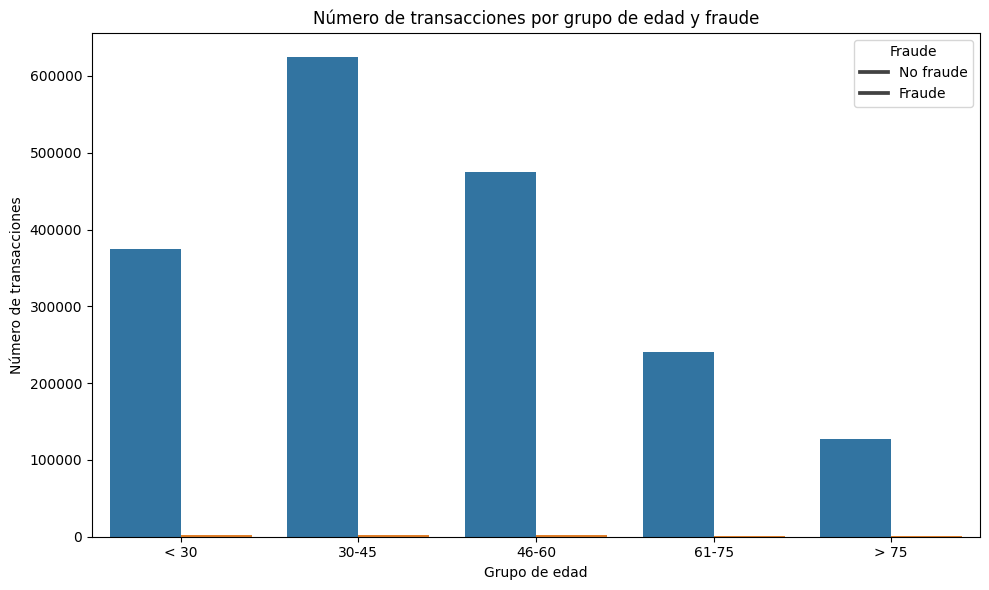

In [43]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=df_fraud_age_group,
    x='age_group',
    y='Transaction count',
    hue='is_fraud'
)
plt.title('Número de transacciones por grupo de edad y fraude')
plt.xlabel('Grupo de edad')
plt.ylabel('Número de transacciones')
plt.legend(title='Fraude', labels=['No fraude','Fraude'])
plt.tight_layout()
plt.show()

- Se observa que la mayoría de transacciones fueron realizadas por clientes pertenecientes al grupo de edad de entre 30 y 45 años. Sin embargo, el grupo de edad de entre 40 y 60 años también ha realizado un número significativo de transacciones.
- El grupo de edad más afectado por transacciones fraudulentas fue el grupo de 61 a 75 años, con aproximadamente un 0.77% de transacciones fraudulentas.

### Cantidad
La cantidad por la que se realizó una transacción es importante en el análisis de fraude. Se obtienen las distribuciones:

In [15]:
pd.concat(
    [df['amt'].describe(percentiles = [0.5,0.95,0.999]).reset_index().rename(columns={'index': 'Row Type', 'amt':'Overall Amt Distribution'}),
     df.loc[df['is_fraud']==0,['amt']].describe(percentiles = [0.5,0.95,0.999]).reset_index(drop = 1).rename(columns={'amt':'Non-Fraud Amt Distribution'}),
     df.loc[df['is_fraud']==1,['amt']].describe(percentiles = [0.5,0.95,0.999]).reset_index(drop = 1).rename(columns={'amt':'Fraud Amt Distribution'})], axis=1)

,Row Type,Overall Amt Distribution,Non-Fraud Amt Distribution,Fraud Amt Distribution
0,count,1.852394e+06,1.842743e+06,9651.000000
1,mean,7.006357e+01,6.765128e+01,530.661412
2,std,1.592540e+02,1.535481e+02,391.028873
3,min,1.000000e+00,1.000000e+00,1.060000
4,50%,4.745000e+01,4.724000e+01,390.000000
5,95%,1.953400e+02,1.895900e+02,1084.090000
6,99.9%,1.517241e+03,1.519623e+03,1293.127000
7,max,2.894890e+04,2.894890e+04,1376.040000


- El promedio de la cantidad por la que se realizan transacciones legítimas es mucho menor al promedio de la cantidad por la que se realizan transacciones fraudulentas. Esto implica que las transacciones fraudulentas suelen realizarse por cantidades mayores de dinero.

c:\Users\Pablo Zamora\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Pablo Zamora\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Pablo Zamora\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


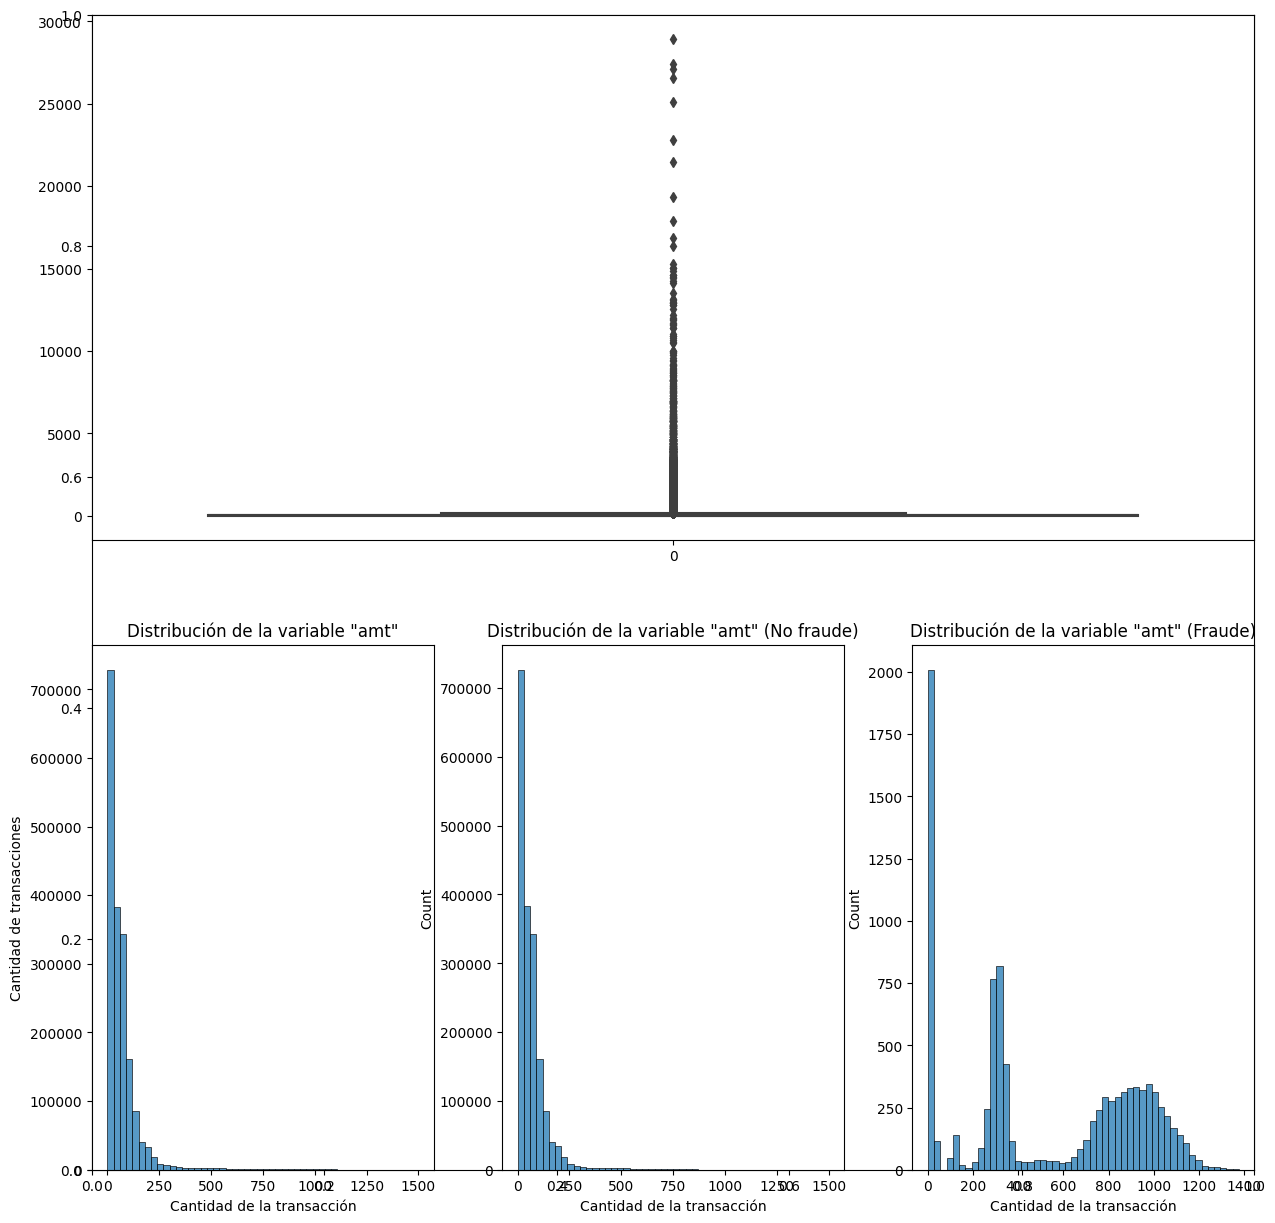

In [ ]:
# Graficando las distribuciones de la variable "amt"
fig = plt.subplots(figsize=(15,15))

plots = []

# Caja y bigotes
plots.append(sns.boxplot(df.amt, ax=plt.subplot(211)))

# Distribución de la variable "amt"
plots.append(sns.histplot(df[df.amt <= 1500].amt, bins=50, ax=plt.subplot(234)))
plots.append(sns.histplot(df[(df.is_fraud==0) & (df.amt<=1500)].amt, bins=50, ax=plt.subplot(235)))
plots.append(sns.histplot(df[(df.is_fraud==1) & (df.amt<=1500)].amt, bins=50, ax=plt.subplot(236)))

plots[1].set_title('Distribución de la variable "amt"')
plots[2].set_title('Distribución de la variable "amt" (No fraude)')
plots[3].set_title('Distribución de la variable "amt" (Fraude)')

plots[1].set_xlabel('Cantidad de la transacción')
plots[2].set_xlabel('Cantidad de la transacción')
plots[3].set_xlabel('Cantidad de la transacción')

plots[1].set_ylabel('Cantidad de transacciones')

# Quitar la escala de 0 a 1 de

plt.show()

- La gráfica de caja y bigotes muestra una gran cantidad de valores atípicos, por lo que la característica de cantidad (amt) presenta una alta varianza.
- La distribución de "amt" de todas las transacciones es sbsatante similar a la distribución de "amt" en transacciones legítimas. Sin embargo, la media de la distribución de "amt" en transacciones fraudulentas parece ser mayor a la de las otras dos.
- Puede notarse un sesgo positivo en las tres distribuciones.

### Características de tiempo
Utilizar las características de tiempo con las que cuenta el conjunto de datos permitirá observar patrones de comportamiento temporales.

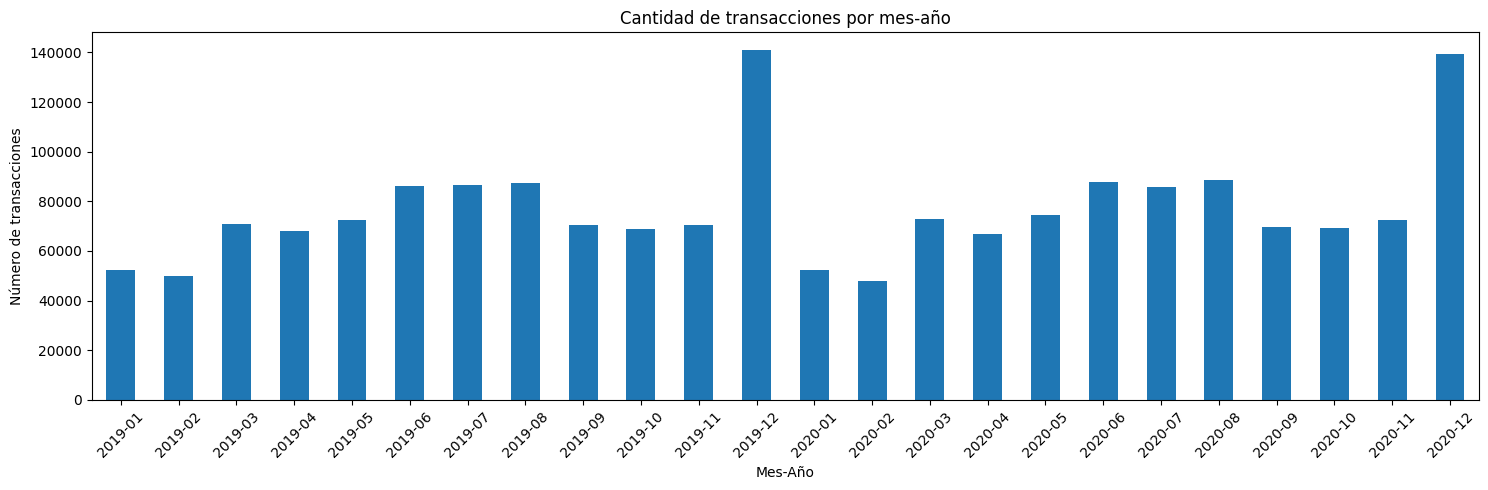

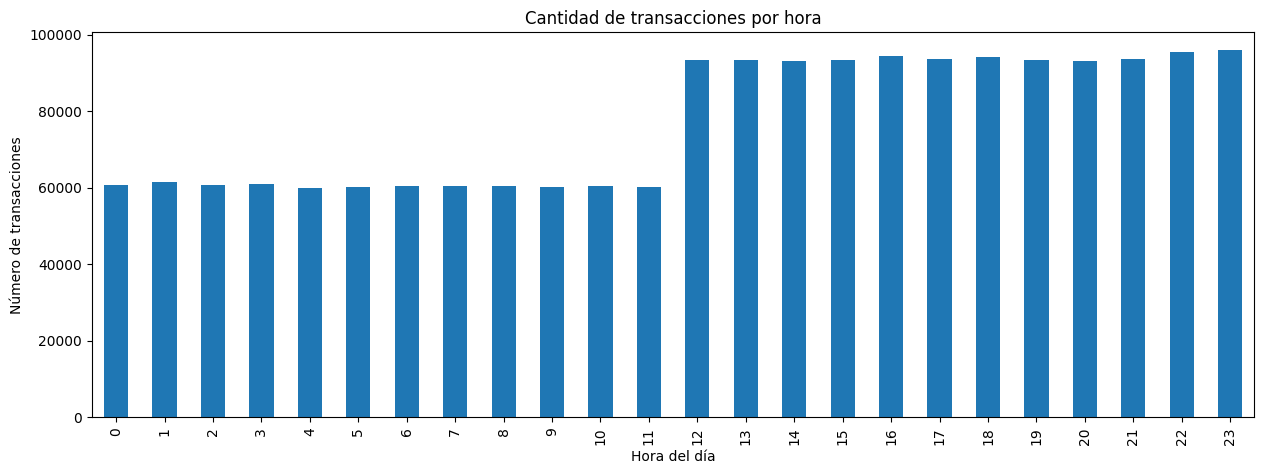

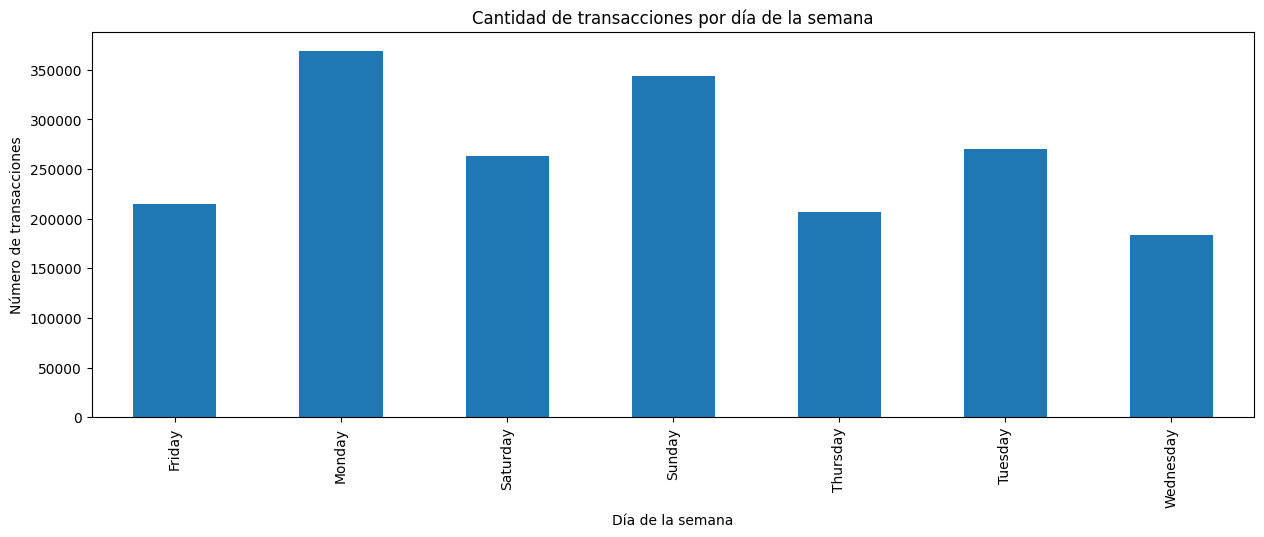

In [44]:
# Transacciones por mes-año
monthly = (
    df
    .groupby(['year','month'])
    .size()
    .reset_index(name='count')
)

monthly['year_month'] = (
    monthly['year'].astype(str) + '-' +
    monthly['month'].astype(int).astype(str).str.zfill(2)
)

monthly.set_index('year_month', inplace=True)
plt.figure(figsize=(15,5))
monthly['count'].plot(kind='bar')
plt.title('Cantidad de transacciones por mes-año')
plt.xlabel('Mes-Año')
plt.ylabel('Número de transacciones')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Transacciones por hora
plt.figure(figsize=(15, 5))
df['transaction_dt'].dt.hour.value_counts().sort_index().plot(kind='bar')
plt.title('Cantidad de transacciones por hora')
plt.xlabel('Hora del día')
plt.ylabel('Número de transacciones')
plt.show()

# Transacciones por día de la semana
plt.figure(figsize=(15, 5))
df['transaction_dt'].dt.day_name().value_counts().sort_index().plot(kind='bar')
plt.title('Cantidad de transacciones por día de la semana')
plt.xlabel('Día de la semana')
plt.ylabel('Número de transacciones')
plt.show()


Número de transacciones y clientes por mes:

In [9]:
# Mostrar 
df['trans_year_month'] = (
    df['year'].astype(str) + '-' +
    df['month'].astype(int).astype(str).str.zfill(2)
)

df_timeline1 = (
    df
    .groupby('trans_year_month')
    .agg(
        num_of_transactions = ('trans_num','count'),
        customers           = ('cc_num'  ,'nunique')
    )
    .reset_index()
)

df_timeline1

,trans_year_month,num_of_transactions,customers
0,2019-01,52525,913
1,2019-02,49866,918
2,2019-03,70939,916
3,2019-04,68078,913
4,2019-05,72532,910
5,2019-06,86064,908
6,2019-07,86596,910
7,2019-08,87359,911
8,2019-09,70652,913
9,2019-10,68758,912


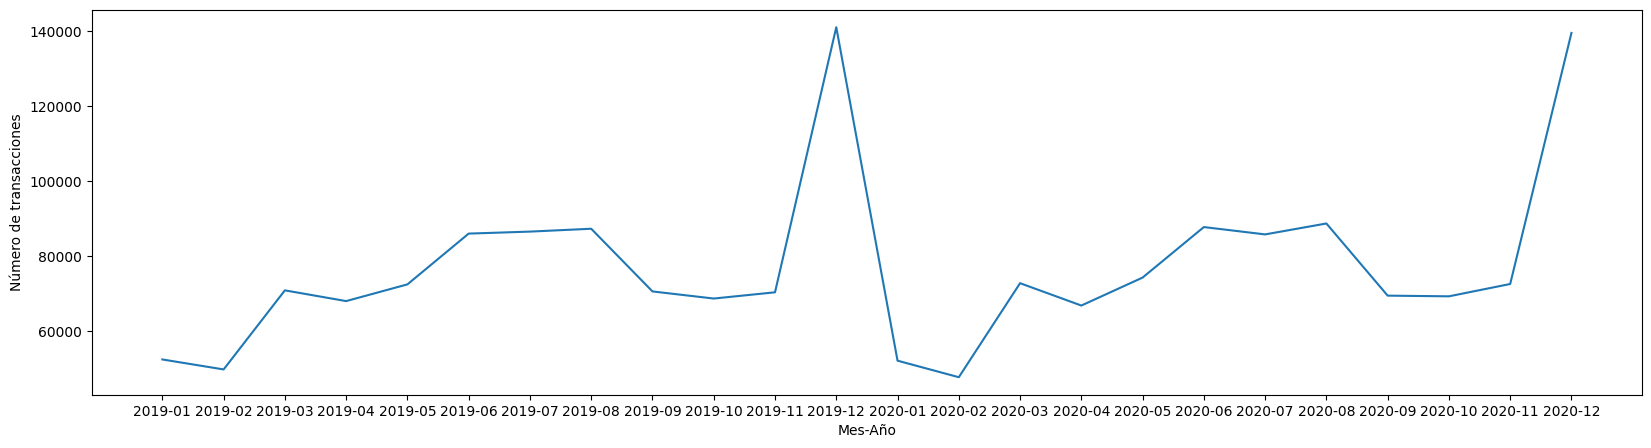

In [47]:
x = np.arange(0,len(df_timeline1),1)

fig, ax = plt.subplots(1,1,figsize=(20,5))
ax.plot(x,df_timeline1['num_of_transactions'])
ax.set_xticks(x)
ax.set_xticklabels(df_timeline1['trans_year_month'])

ax.set_xlabel('Mes-Año')
ax.set_ylabel('Número de transacciones')
plt.show()

Número de transacciones fraudulentas por mes:

In [48]:
df_fraud_transactions = df[df['is_fraud']==1]

df_timeline2 = df_fraud_transactions.groupby(df_fraud_transactions['trans_year_month'])[['trans_num','cc_num']].nunique().reset_index()
df_timeline2.columns = ['year_month','num_of_fraud_transactions','fraud_customers']
df_timeline2

,year_month,num_of_fraud_transactions,fraud_customers
0,2019-01,506,50
1,2019-02,517,53
2,2019-03,494,49
3,2019-04,376,41
4,2019-05,408,42
5,2019-06,354,35
6,2019-07,331,36
7,2019-08,382,39
8,2019-09,418,44
9,2019-10,454,50


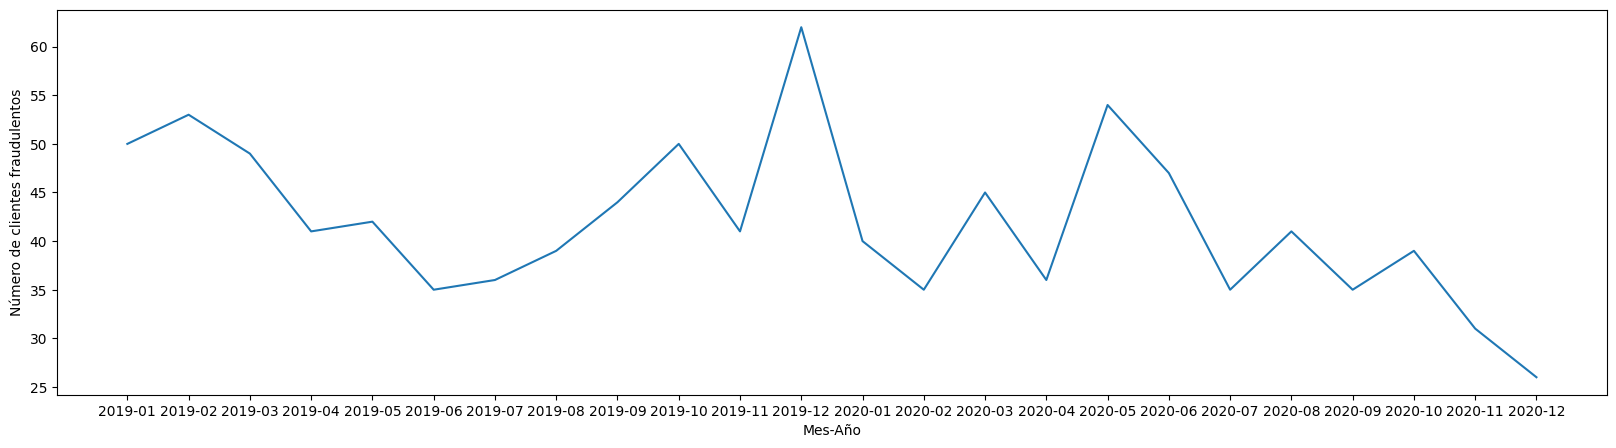

In [49]:
x = np.arange(0,len(df_timeline2),1)

fig, ax = plt.subplots(1,1,figsize=(20,5))
ax.plot(x,df_timeline2['fraud_customers'])
ax.set_xticks(x)
ax.set_xticklabels(df_timeline2['year_month'])

ax.set_xlabel('Mes-Año')
ax.set_ylabel('Número de clientes fraudulentos')
plt.show()

- La mayoría de transacciones ocurrieron después del mediodía.
- Se observan los mayores picos de transacciones en diciembre de 2019 y diciembre 2020. De manera análoga, el pico más alto de clientes fraudulentos ocurre en diciembre de 2019. Por tanto, es posible inferir que se producen más fraudes durante las festividades.

### Características de ubicación
Es posible obtener información relevante de la ubicación en la que se realizaron las transacciones.

Estado:

In [55]:
df.state.nunique()

51

In [ ]:
# Los los 20 estados con mayores transacciones
high_trans_states = df.state.value_counts().head(20).index.tolist()
print(high_trans_states)

['TX', 'NY', 'PA', 'CA', 'OH', 'MI', 'IL', 'FL', 'AL', 'MO', 'MN', 'AR', 'NC', 'VA', 'WI', 'SC', 'KY', 'IN', 'IA', 'OK']


In [ ]:
# Porcentaje de transacciones por estado
100*df[df.state.isin(high_trans_states)].state.value_counts(normalize=True)

state
TX    10.961858
NY     9.677414
PA     9.252292
CA     6.523111
OH     5.399284
MI     5.334292
IL     5.041503
FL     4.925052
AL     4.742394
MO     4.449281
MN     3.681776
AR     3.615163
NC     3.495470
VA     3.383801
WI     3.382342
SC     3.381775
KY     3.320997
IN     3.204141
IA     3.144578
OK     3.083476
Name: proportion, dtype: float64

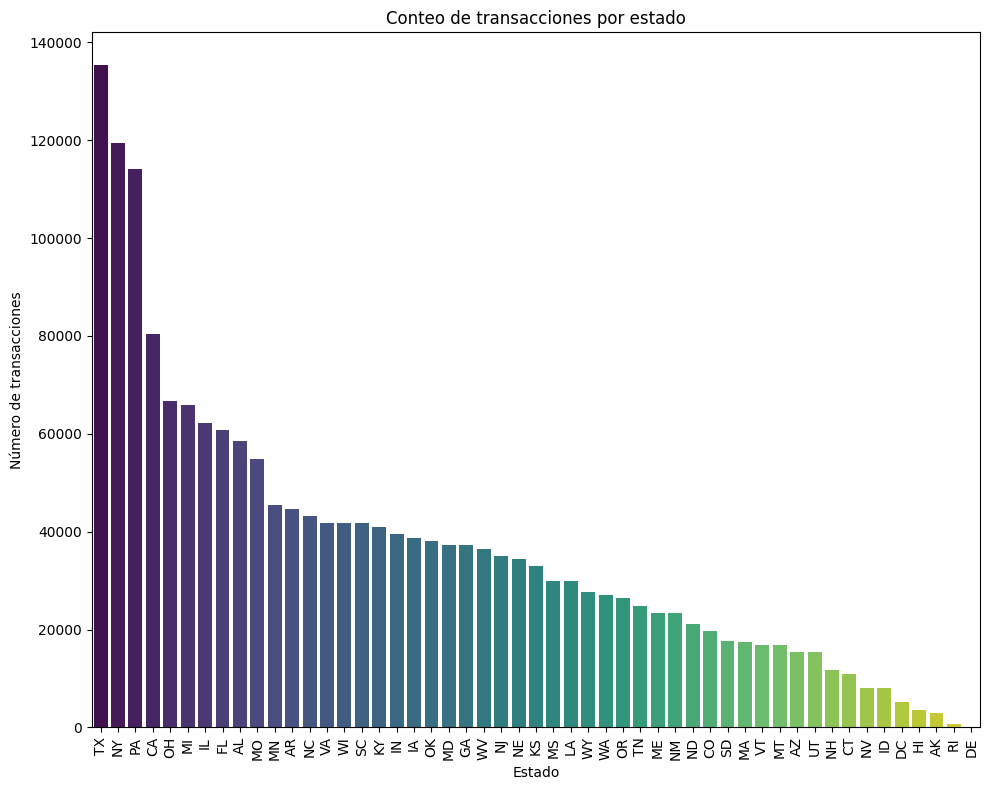

In [59]:
plt.figure(figsize=(10,8))
sns.countplot(
    data=df,
    x='state',
    order=df['state'].value_counts().index,
    palette='viridis'
)
plt.xticks(rotation=90)
plt.title('Conteo de transacciones por estado')
plt.xlabel('Estado')
plt.ylabel('Número de transacciones')
plt.tight_layout()
plt.show()

In [63]:
# Distribución de los 20 estados con mayor porcentaje de transacciones fraudulentas
df_state = df[['state','trans_num']].groupby(['state']).count().reset_index()
df_state.columns = ['state', 'state_count']

df_fraud_state = df[['state', 'trans_num', 'is_fraud']].groupby(['state','is_fraud']).count().reset_index()
df_fraud_state.columns = ['state', 'is_fraud', 'Transaction count']

df_fraud_state = df_fraud_state.merge(df_state[['state', 'state_count']], how='inner', on='state')

df_fraud_state['Transaction percentage'] = (df_fraud_state['Transaction count']/df_fraud_state['state_count'])*100

df_fraud_state[df_fraud_state['is_fraud'] == 1].sort_values(by = ['Transaction percentage'], ascending=False)

,state,is_fraud,Transaction count,state_count,Transaction percentage
16,DE,1,9,9,100.000000
78,RI,1,15,745,2.013423
1,AK,1,50,2963,1.687479
74,OR,1,197,26408,0.745986
60,NH,1,79,11727,0.673659
90,VA,1,273,41756,0.653798
84,TN,1,159,24913,0.638221
58,NE,1,216,34425,0.627451
46,MN,1,280,45433,0.616292
68,NY,1,730,119419,0.611293


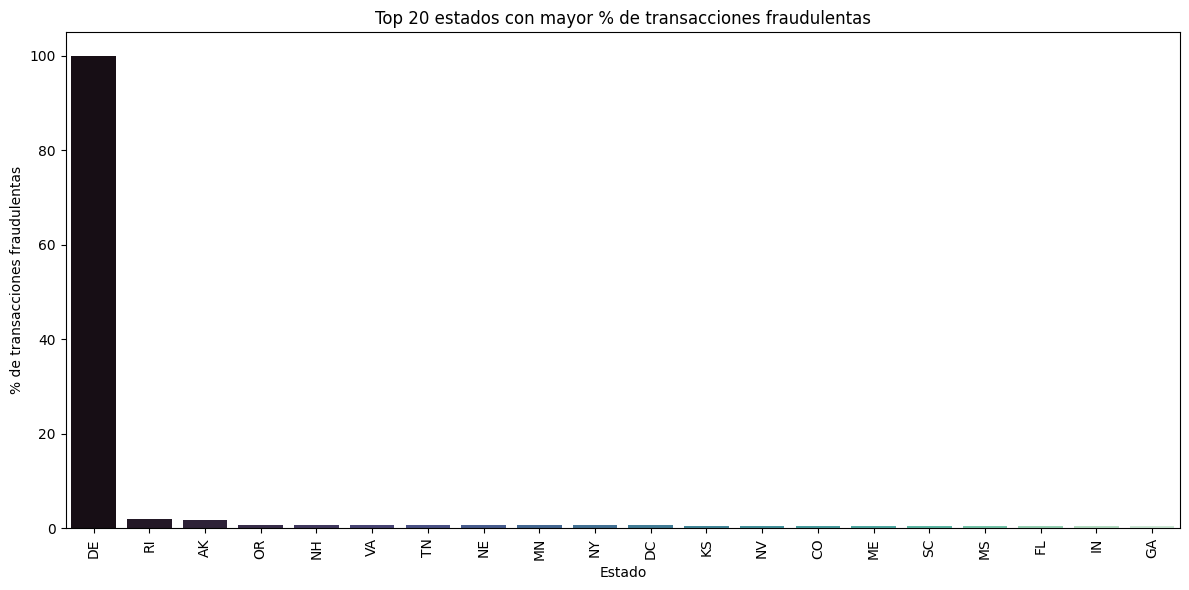

In [ ]:
top20 = (
    df_fraud_state
    .query("is_fraud == 1")
    .nlargest(20, 'Transaction percentage')
)

plt.figure(figsize=(12,6))
sns.barplot(
    data=top20,
    x='state',
    y='Transaction percentage',
    palette='mako'
)
plt.xticks(rotation=90)
plt.title('Top 20 estados con mayor % de transacciones fraudulentas')
plt.xlabel('Estado')
plt.ylabel('% de transacciones fraudulentas')
plt.tight_layout()
plt.show()

- Los estados con mayor número de transacciones son "TX", "NY", "PA", "CA" y "OH".
- En los estados con mayor número de transacciones cuentan con aproximadamente un 0.5% de transacciones fraudulentas.
- El estado con mayor porcentaje de transacciones fraudulentas es "DE"; sin embargo, es un estado atípico, ya que las pocas transacciones registradas de este son todas fraudulentas.

Ciudad y código postal:

In [64]:
print('Número de ciudades: ',df.city.nunique())
print('Número de códigos postales: ',df.zip.nunique())

Número de ciudades:  906
Número de códigos postales:  985


In [65]:
high_trans_cities = df.city.value_counts().head(20).index.tolist()
high_trans_zips = df.zip.value_counts().head(20).index.tolist()
print('Ciudades con mayor número de transacciones: ', high_trans_cities)
print('Códigos postales con mayor número de transacciones: ', high_trans_zips)

Ciudades con mayor número de transacciones:  ['Birmingham', 'San Antonio', 'Utica', 'Phoenix', 'Meridian', 'Warren', 'Conway', 'Cleveland', 'Thomas', 'Houston', 'Arcadia', 'Naples', 'Brandon', 'Fulton', 'Indianapolis', 'Burbank', 'Dallas', 'Washington', 'Detroit', 'Hudson']
Códigos postales con mayor número de transacciones:  [82514, 73754, 48088, 34112, 61454, 16114, 89512, 72476, 84540, 72042, 33872, 46346, 12419, 29438, 15484, 5461, 85173, 6024, 7060, 58569]


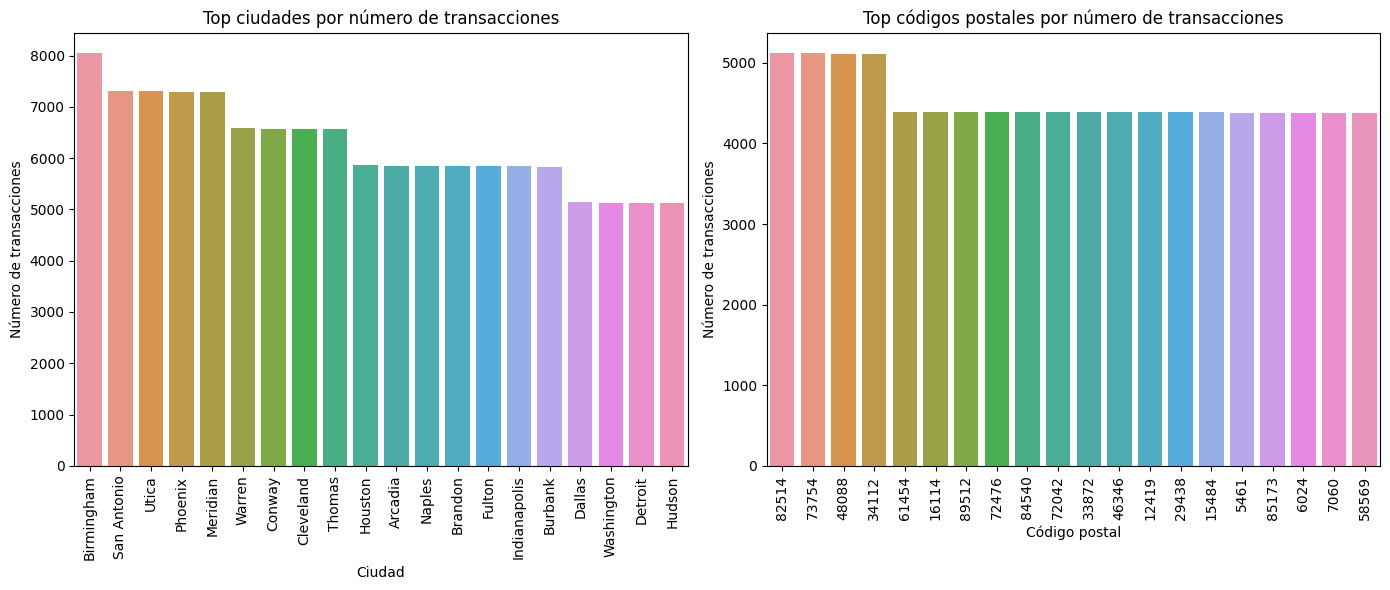

In [69]:
# Ciudades y códigos postales con mayor número de transacciones
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot ciudades
sns.countplot(
    data=df[df.city.isin(high_trans_cities)],
    x='city',
    order=high_trans_cities,
    ax=ax1
)
ax1.set_title('Top ciudades por número de transacciones')
ax1.set_xlabel('Ciudad')
ax1.set_ylabel('Número de transacciones')
ax1.tick_params(axis='x', rotation=90)

# Plot códigos postales
sns.countplot(
    data=df[df.zip.isin(high_trans_zips)],
    x='zip',
    order=high_trans_zips,
    ax=ax2
)
ax2.set_title('Top códigos postales por número de transacciones')
ax2.set_xlabel('Código postal')
ax2.set_ylabel('Número de transacciones')
ax2.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

In [ ]:
df_city = df[['city','trans_num']].groupby(['city']).count().reset_index()
df_city.columns = ['city', 'city_count']

df_fraud_city = df[['city', 'trans_num', 'is_fraud']].groupby(['city','is_fraud']).count().reset_index()
df_fraud_city.columns = ['city', 'is_fraud', 'Transaction count']

df_fraud_city = df_fraud_city.merge(df_city[['city', 'city_count']], how='inner', on='city')

df_fraud_city['Transaction percentage'] = (df_fraud_city['Transaction count']/df_fraud_city['city_count'])*100

df_fraud_city[df_fraud_city['is_fraud'] == 1].sort_values(by = ['Transaction percentage'], ascending=False).head(20)

,city,is_fraud,Transaction count,city_count,Transaction percentage
1322,Rice,1,8,8,100.0
1106,Norfolk,1,7,7,100.0
1325,Ridge Spring,1,10,10,100.0
445,East China,1,9,9,100.0
1294,Queen Anne,1,13,13,100.0
1627,Waukau,1,10,10,100.0
1247,Pleasant Hill,1,8,8,100.0
528,Freeport,1,9,9,100.0
1231,Phelps,1,11,11,100.0
109,Beacon,1,11,11,100.0


In [70]:
df_zip = df[['zip','trans_num']].groupby(['zip']).count().reset_index()
df_zip.columns = ['zip', 'zip_count']

df_fraud_zip = df[['zip', 'trans_num', 'is_fraud']].groupby(['zip','is_fraud']).count().reset_index()
df_fraud_zip.columns = ['zip', 'is_fraud', 'Transaction count']

df_fraud_zip = df_fraud_zip.merge(df_zip[['zip', 'zip_count']], how='inner', on='zip')

df_fraud_zip['Transaction percentage'] = (df_fraud_zip['Transaction count']/df_fraud_zip['zip_count'])*100

df_fraud_zip[df_fraud_zip['is_fraud'] == 1].sort_values(by = ['Transaction percentage'], ascending=False).head(20)

,zip,is_fraud,Transaction count,zip_count,Transaction percentage
1859,99921,1,14,14,100.0
126,10533,1,8,8,100.0
930,47842,1,12,12,100.0
941,48054,1,9,9,100.0
960,48436,1,8,8,100.0
1035,52658,1,6,6,100.0
1040,53045,1,9,9,100.0
1052,53559,1,10,10,100.0
234,14532,1,11,11,100.0
1082,54980,1,10,10,100.0


c:\Users\Pablo Zamora\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\Pablo Zamora\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


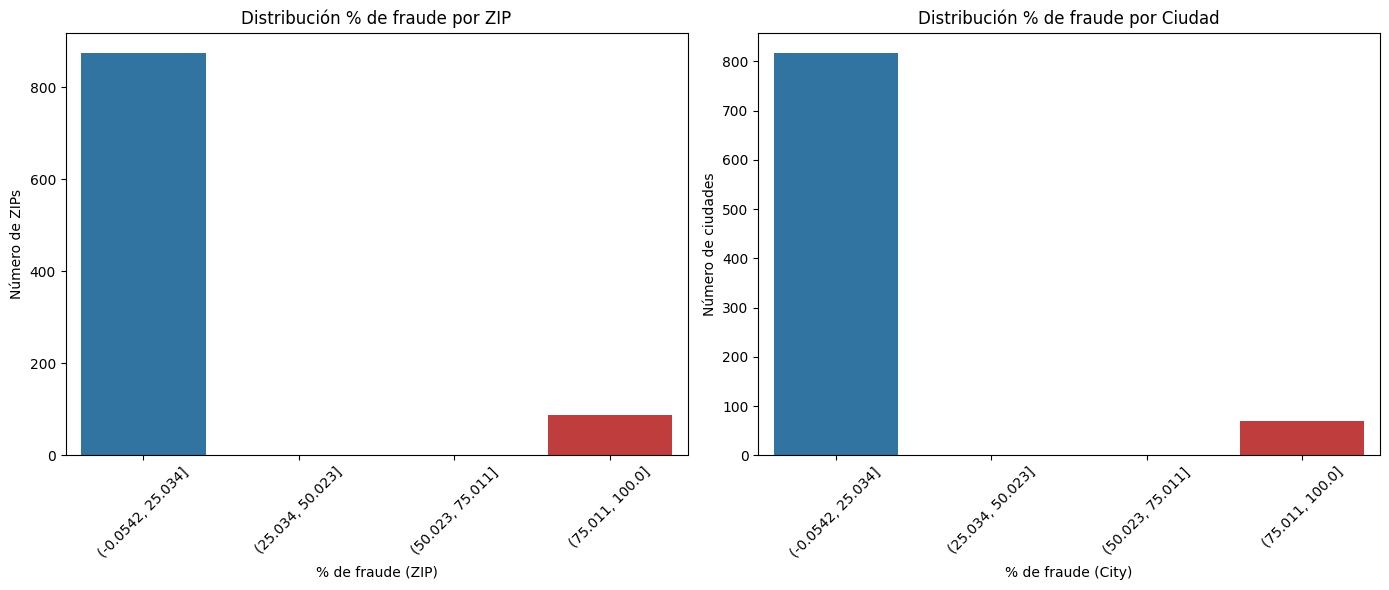

In [72]:
# Filtrar solo porcentajes de fraude
zip_pct = df_fraud_zip.loc[df_fraud_zip.is_fraud == 1, 'Transaction percentage']
city_pct = df_fraud_city.loc[df_fraud_city.is_fraud == 1, 'Transaction percentage']

# Crear bins
zip_bins = pd.cut(zip_pct, bins=4)
city_bins = pd.cut(city_pct, bins=4)

# Graficar en dos subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

sns.countplot(x=zip_bins, ax=ax1)
ax1.set_title('Distribución % de fraude por ZIP')
ax1.set_xlabel('% de fraude (ZIP)')
ax1.set_ylabel('Número de ZIPs')
ax1.tick_params(axis='x', rotation=45)

sns.countplot(x=city_bins, ax=ax2)
ax2.set_title('Distribución % de fraude por Ciudad')
ax2.set_xlabel('% de fraude (City)')
ax2.set_ylabel('Número de ciudades')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [73]:
# Ciudades y códigos postales con un porcentaje de transacciones fraudulentas mayor al 75%
print('Ciudades con más del 75% de transacciones fraudulentas:\n')
print(df_fraud_city.loc[(df_fraud_city.is_fraud == 1) & (df_fraud_city['Transaction percentage'] >= 75)].city.tolist())
print('\n\nCódigos postales con más del 75% de transacciones fraudulentas:\n')
print(df_fraud_zip.loc[(df_fraud_zip.is_fraud == 1) & (df_fraud_zip['Transaction percentage'] >= 75)].zip.tolist())

Ciudades con más del 75% de transacciones fraudulentas:

['Angwin', 'Ashland', 'Beacon', 'Brookfield', 'Bruce', 'Buellton', 'Byesville', 'Chattanooga', 'Clarion', 'Claypool', 'Clinton', 'Coulee Dam', 'Craig', 'Crouse', 'Downey', 'East China', 'Freeport', 'Gaines', 'Granbury', 'Greenport', 'Grenola', 'Grifton', 'Guthrie', 'Hubbell', 'Irvington', 'Isanti', 'Kaktovik', 'Karns City', 'Kirkwood', 'Kirtland', 'La Grande', 'Las Vegas', 'Lexington', 'Lockhart', 'Madisonville', 'Marshall', 'Medford', 'Melville', 'Mineral', 'Morrowville', 'Morven', 'Moss Point', 'Mount Vernon', 'Mountain City', 'Nanuet', 'Nicholson', 'Noblesville', 'Norfolk', 'North East', 'Oakton', 'Orange Park', 'Phelps', 'Pleasant Hill', 'Queen Anne', 'Rice', 'Ridge Spring', 'Roland', 'Seattle', 'Seligman', 'Senatobia', 'Springville', 'Streator', 'Vacaville', 'Walkertown', 'Wappapello', 'Wartburg', 'Waukau', 'West Frankfort', 'Wever', 'Winnsboro']


Códigos postales con más del 75% de transacciones fraudulentas:

[4032, 10018

- Se observa en el conteo de porcentajes de transacciones fraudulentas que tanto las ciudades como los códigos ZIP caen mayormente en dos rangos: De 0% a 25% o de 75% a 100%.
- 50 códigos postales y 70 ciudades poseen un porcentaje de transacciones fraudulentas mayor al 75%

### Trabajo

In [74]:
df.job.nunique()

497

Esta característica cuenta con demasiados valores únicos, por lo que se analizarán los 20 más frecuentes.

In [75]:
high_trans_jobs = df.job.value_counts().head(20).index.tolist()
print(high_trans_jobs)

['Film/video editor', 'Exhibition designer', 'Surveyor, land/geomatics', 'Naval architect', 'Materials engineer', 'Designer, ceramics/pottery', 'Environmental consultant', 'Financial adviser', 'Systems developer', 'IT trainer', 'Copywriter, advertising', 'Scientist, audiological', 'Chartered public finance accountant', 'Chief Executive Officer', 'Podiatrist', 'Comptroller', 'Magazine features editor', 'Agricultural consultant', 'Paramedic', 'Sub']


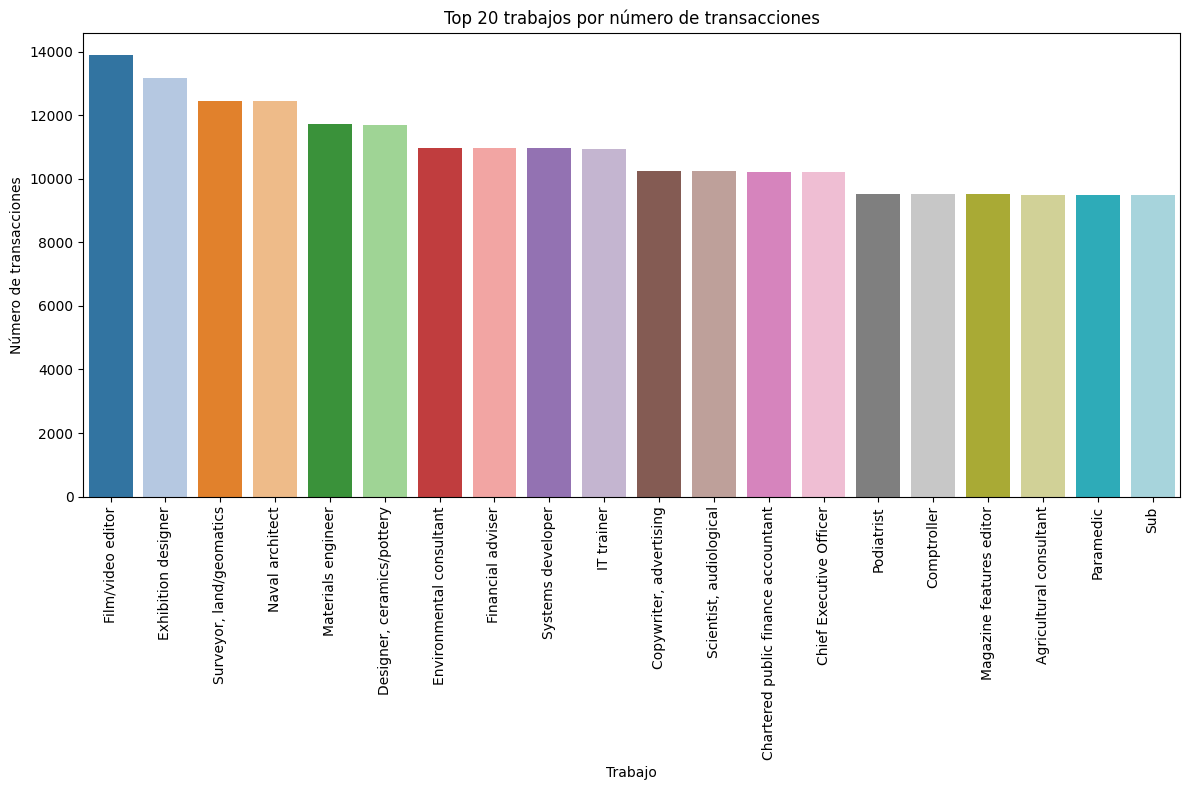

In [77]:
# Cantidad de transacciones por trabajo
high_trans_jobs = df['job'].value_counts().head(20).index.tolist()
fig, ax = plt.subplots(figsize=(12, 8))

sns.countplot(
    data=df[df['job'].isin(high_trans_jobs)],
    x='job',
    order=high_trans_jobs,
    ax=ax,
    palette='tab20'
)

ax.set_title('Top 20 trabajos por número de transacciones')
ax.set_xlabel('Trabajo')
ax.set_ylabel('Número de transacciones')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()

In [78]:
# Distribución de los trabajos con mayor porcentaje de transacciones fraudulentas
df_job = df[['job','trans_num']].groupby(['job']).count().reset_index()
df_job.columns = ['job', 'job_count']

df_fraud_job = df[['job', 'trans_num', 'is_fraud']].groupby(['job','is_fraud']).count().reset_index()
df_fraud_job.columns = ['job', 'is_fraud', 'Transaction count']

df_fraud_job = df_fraud_job.merge(df_job[['job', 'job_count']], how='inner', on='job')

df_fraud_job['Transaction percentage'] = (df_fraud_job['Transaction count']/df_fraud_job['job_count'])*100

df_fraud_job[df_fraud_job['is_fraud'] == 1].sort_values(by = ['Transaction percentage'], ascending=False).head(20)

,job,is_fraud,Transaction count,job_count,Transaction percentage
444,Homeopath,1,11,11,100.0
2,"Accountant, chartered",1,11,11,100.0
393,Forest/woodland manager,1,9,9,100.0
834,Software engineer,1,11,11,100.0
827,Ship broker,1,7,7,100.0
68,Armed forces technical officer,1,8,8,100.0
228,Dancer,1,19,19,100.0
796,Sales promotion account executive,1,14,14,100.0
39,Air traffic controller,1,17,17,100.0
99,Broadcast journalist,1,9,9,100.0


c:\Users\Pablo Zamora\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


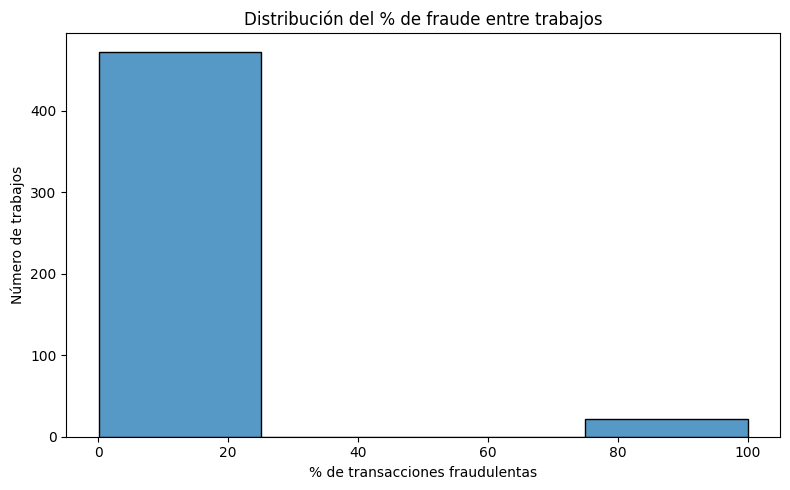

In [82]:
plt.figure(figsize=(8,5))
sns.histplot(
    data=df_fraud_job.query("is_fraud == 1"),
    x='Transaction percentage',
    bins=4,
    kde=False
)

plt.title('Distribución del % de fraude entre trabajos')
plt.xlabel('% de transacciones fraudulentas')
plt.ylabel('Número de trabajos')
plt.tight_layout()
plt.show()

In [83]:
# Trabajos con más el 50% de transacciones fraudulentas
df_fraud_job.loc[(df_fraud_job.is_fraud == 1) & (df_fraud_job['Transaction percentage'] >= 50)].job.tolist()

['Accountant, chartered',
 'Air traffic controller',
 'Armed forces technical officer',
 'Broadcast journalist',
 'Careers adviser',
 'Contracting civil engineer',
 'Dancer',
 'Engineer, site',
 'Engineer, water',
 'Forest/woodland manager',
 'Homeopath',
 'Industrial buyer',
 'Information officer',
 'Legal secretary',
 'Operational investment banker',
 'Personnel officer',
 'Sales promotion account executive',
 'Ship broker',
 'Software engineer',
 'Solicitor',
 'Veterinary surgeon',
 'Warehouse manager']

- Las gráficas anteriores muestran que la gran mayoría de trabajos presentan un porcentaje de transacciones fraudulentas de entre 0% y 20%, mientras que una poca cantidad de trabajos cuentan con un porcentaje de transacciones fraudulentes de entre 80% y 100%.

## Categoría
La característica de "category" podría permitir identificar patrones en cuanto a la razón de compra sobre la que se realiza una transacción fraudulenta.

In [ ]:
# Porcentaje de transacciones por categoría
df.category.value_counts(normalize=True)

category
gas_transport     0.101506
grocery_pos       0.095115
home              0.094721
shopping_pos      0.089864
kids_pets         0.087307
shopping_net      0.075212
entertainment     0.072403
food_dining       0.070573
personal_care     0.070225
health_fitness    0.066159
misc_pos          0.061666
misc_net          0.048939
grocery_net       0.035024
travel            0.031287
Name: proportion, dtype: float64

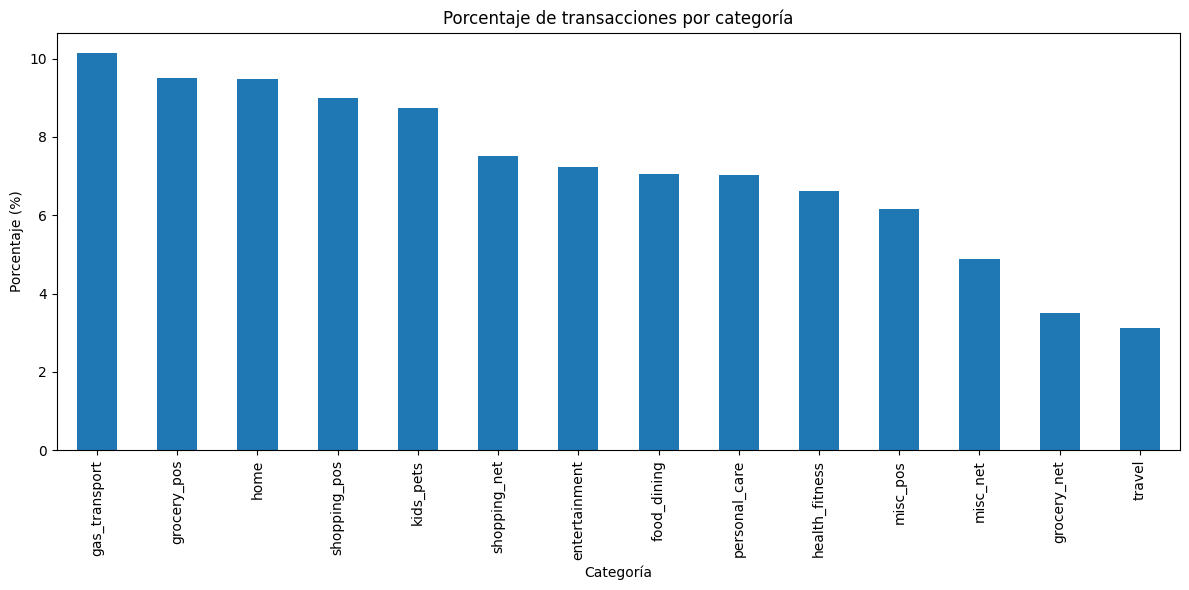

In [86]:
# Serie de % por categoría
pct = df['category'].value_counts(normalize=True) * 100

plt.figure(figsize=(12,6))
pct.plot(kind='bar')
plt.title('Porcentaje de transacciones por categoría')
plt.xlabel('Categoría')
plt.ylabel('Porcentaje (%)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

plt.show()

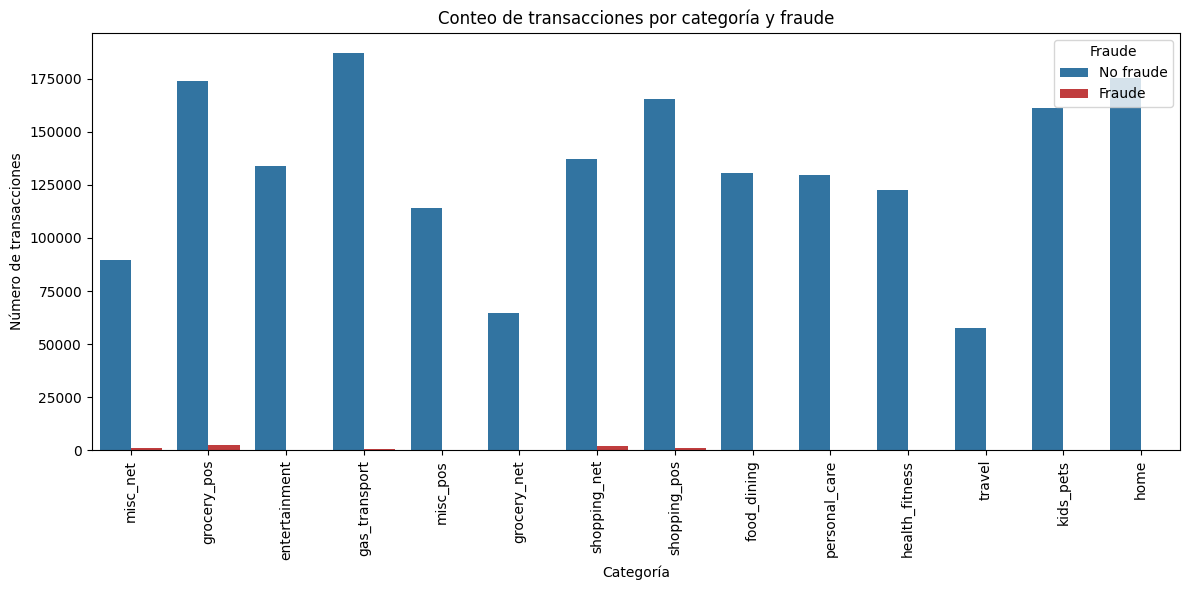

In [87]:
# Conteo de transacciones por categoría

plt.figure(figsize=(12,6))
ax = sns.countplot(
    data=df,
    x='category',
    hue='is_fraud',
    palette={0: 'C0', 1: 'C3'}   # opcional: colores distintos para no fraude (0) y fraude (1)
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Conteo de transacciones por categoría y fraude')
ax.set_xlabel('Categoría')
ax.set_ylabel('Número de transacciones')
ax.legend(title='Fraude', labels=['No fraude','Fraude'])
plt.tight_layout()
plt.show()

In [ ]:
df_category = df[['category','trans_num']].groupby(['category']).count().reset_index()
df_category.columns = ['category', 'category_count']

df_fraud_category = df[['category', 'trans_num', 'is_fraud']].groupby(['category','is_fraud']).count().reset_index()
df_fraud_category.columns = ['category', 'is_fraud', 'Transaction count']

df_fraud_category = df_fraud_category.merge(df_category[['category', 'category_count']], how='inner', on='category')

df_fraud_category['Transaction percentage'] = (df_fraud_category['Transaction count']/df_fraud_category['category_count'])*100

df_fraud_category[df_fraud_category['is_fraud'] == 1].sort_values(by = ['Transaction percentage'], ascending=False)

,category,is_fraud,Transaction count,category_count,Transaction percentage
23,shopping_net,1,2219,139322,1.592713
17,misc_net,1,1182,90654,1.303859
9,grocery_pos,1,2228,176191,1.264537
25,shopping_pos,1,1056,166463,0.634375
5,gas_transport,1,772,188029,0.410575
19,misc_pos,1,322,114229,0.281890
7,grocery_net,1,175,64878,0.269737
27,travel,1,156,57956,0.269170
21,personal_care,1,290,130085,0.222931
1,entertainment,1,292,134118,0.217719


c:\Users\Pablo Zamora\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


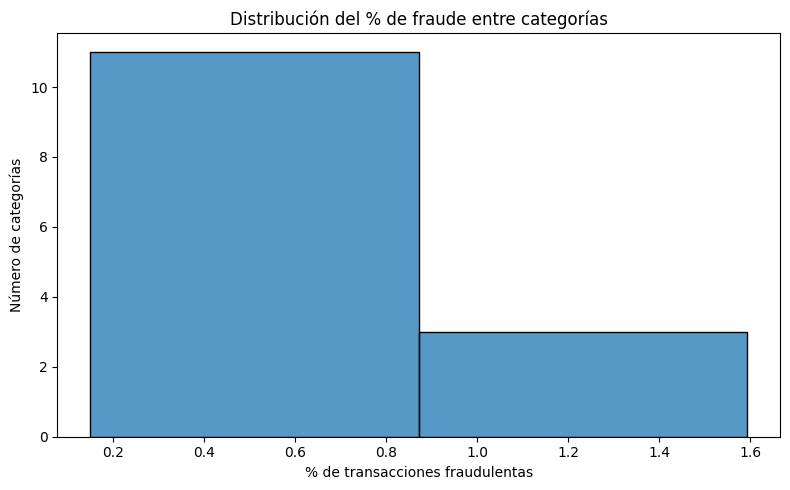

In [89]:
plt.figure(figsize=(8,5))
sns.histplot(
    data=df_fraud_category.query("is_fraud == 1"),
    x='Transaction percentage',
    bins=2,
    kde=False
)
plt.title('Distribución del % de fraude entre categorías')
plt.xlabel('% de transacciones fraudulentas')
plt.ylabel('Número de categorías')
plt.tight_layout()
plt.show()

In [90]:
# Categorías con más del 1.0% de transacciones fraudulentas
df_fraud_category.loc[(df_fraud_category.is_fraud == 1) & (df_fraud_category['Transaction percentage'] >= 1)].category

9      grocery_pos
17        misc_net
23    shopping_net
Name: category, dtype: object

- Las gráficas y tablas anteriores demuestran que únicamente 3 categorías tienen un porcentaje de transacciones fraudulentas mayor al 1.0%: "grocery_pos", "misc_net", y "shopping_net". De estas, "shopping_net" tiene la mayor cantidad de transacciones fraudulentas.

### Comerciante

In [91]:
df.merchant.nunique()

693

Hay casi 700 valores únicos para la característica de "merchant", por lo que se trabajará con los 20 comerciantes más frecuentes.

In [92]:
high_trans_merchants = df.merchant.value_counts().head(20).index.tolist()
high_trans_merchants

['fraud_Kilback LLC',
 'fraud_Cormier LLC',
 'fraud_Schumm PLC',
 'fraud_Kuhn LLC',
 'fraud_Boyer PLC',
 'fraud_Dickinson Ltd',
 'fraud_Emard Inc',
 'fraud_Cummerata-Jones',
 'fraud_Corwin-Collins',
 'fraud_Rodriguez Group',
 'fraud_Kling Inc',
 'fraud_Parisian and Sons',
 'fraud_Erdman-Kertzmann',
 'fraud_Huels-Hahn',
 'fraud_Stroman, Hudson and Erdman',
 'fraud_Kutch LLC',
 'fraud_Jenkins, Hauck and Friesen',
 'fraud_Prohaska-Murray',
 'fraud_Olson, Becker and Koch',
 'fraud_Eichmann, Bogan and Rodriguez']

In [93]:
# Comerciantes con mayor porcentaje de transacciones fraudulentas

df_merchant = df[['merchant','trans_num']].groupby(['merchant']).count().reset_index()
df_merchant.columns = ['merchant', 'merchant_count']

df_fraud_merchant = df[['merchant', 'trans_num', 'is_fraud']].groupby(['merchant','is_fraud']).count().reset_index()
df_fraud_merchant.columns = ['merchant', 'is_fraud', 'Transaction count']

df_fraud_merchant = df_fraud_merchant.merge(df_merchant[['merchant', 'merchant_count']], how='inner', on='merchant')

df_fraud_merchant['Transaction percentage'] = (df_fraud_merchant['Transaction count']/df_fraud_merchant['merchant_count'])*100

df_fraud_merchant[df_fraud_merchant['is_fraud'] == 1].sort_values(by = ['Transaction percentage'], ascending=False).head(20)

,merchant,is_fraud,Transaction count,merchant_count,Transaction percentage
673,fraud_Kozey-Boehm,1,60,2758,2.175489
490,"fraud_Herman, Treutel and Dickens",1,38,1870,2.032086
1226,fraud_Terry-Huel,1,56,2864,1.955307
607,fraud_Kerluke-Abshire,1,50,2635,1.897533
884,"fraud_Mosciski, Ziemann and Farrell",1,53,2821,1.878766
1105,"fraud_Schmeler, Bashirian and Price",1,52,2788,1.865136
691,fraud_Kuhic LLC,1,53,2842,1.864884
563,fraud_Jast Ltd,1,51,2757,1.849837
743,"fraud_Langworth, Boehm and Gulgowski",1,52,2817,1.845935
1051,"fraud_Romaguera, Cruickshank and Greenholt",1,51,2767,1.843151


c:\Users\Pablo Zamora\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


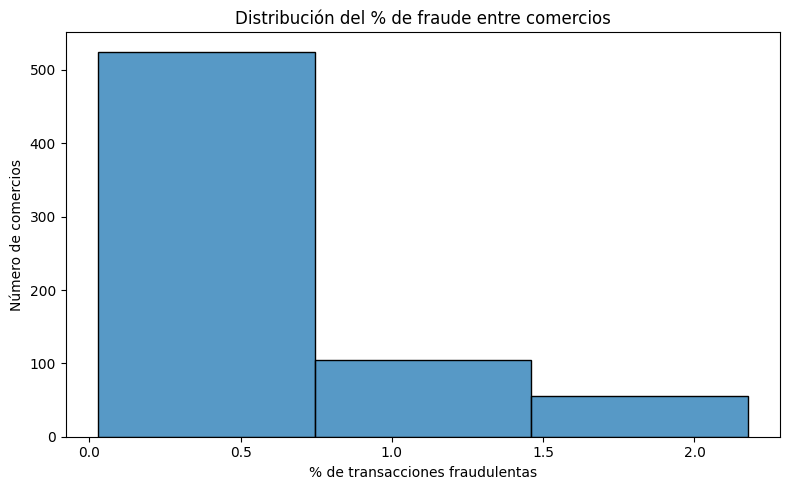

In [94]:
# Cantidad de comerciantes por porcentaje de transacciones fraudulentas
plt.figure(figsize=(8,5))
sns.histplot(
    data=df_fraud_merchant.query("is_fraud == 1"),
    x='Transaction percentage',
    bins=3,
    kde=False
)
plt.title('Distribución del % de fraude entre comercios')
plt.xlabel('% de transacciones fraudulentas')
plt.ylabel('Número de comercios')
plt.tight_layout()
plt.show()


In [97]:
# Cantidad de comerciantes con más del 1.0% de transacciones fraudulentas
len(df_fraud_merchant.loc[(df_fraud_merchant.is_fraud == 1) & (df_fraud_merchant['Transaction percentage'] >= 1)].merchant)

139

- Las gráficas anteriores demuestran que 139 comerciantes cuentan con un porcentaje de transacciones fraudulentas mayor a 1.0%.
- Además, los únicos comerciantes con un porcentaje de transacciones fraudulentas mayor a 2.0% son "fraud_Kozey-Boehm" y "fraud_Herman, Treutel and Dickens".

## Ingeniería de Características (FE)

Durante el análisis exploratorio ya se agregaron características al dataframe de datos, tales como *age* (edad), *age_group* (grupo de edad) y *trans_month_year* (mes y año de transacción):

In [7]:
df['age_group'].value_counts(normalize=True)

age_group
30-45    0.338735
46-60    0.257562
< 30     0.203289
61-75    0.130981
> 75     0.069433
Name: proportion, dtype: float64

In [10]:
df['trans_year_month'].head(10)

0    2019-01
1    2019-01
2    2019-01
3    2019-01
4    2019-01
5    2019-01
6    2019-01
7    2019-01
8    2019-01
9    2019-01
Name: trans_year_month, dtype: object

### Determinar si la transacción se realizó entre semana o en fin de semana

Esta podría ser una característica útil, ya que las transacciones fraudulentas podrían haberse realizado mayormente durante fines de semana (o, en su defecto, entre semana).

In [11]:
df['is_weekend'] = df['dow'] >= 5
df['is_weekend']

0          False
1          False
2          False
3          False
4          False
           ...  
1852389    False
1852390    False
1852391    False
1852392    False
1852393    False
Name: is_weekend, Length: 1852394, dtype: bool

### Tiempo desde la última transacción con el mismo comerciante (merchant)

Esta característica podría aportar relevancia a la frecuencia con la que un cliente realiza transacciones con un comerciante, ya que son más sospechosas aquellas transacciones con comerciantes poco frecuentados por el cliente.

In [12]:
df = df.sort_values(['cc_num','merchant','transaction_dt'])
df['hours_since_last'] = (
    df.groupby(['cc_num','merchant'])['transaction_dt']
      .diff().dt.total_seconds() / 3600
)

df['hours_since_last'] = df['hours_since_last'].fillna(0)
df['hours_since_last']

250959         0.000000
565695      2768.460833
1157285     5826.830000
306182         0.000000
583905      2380.332222
               ...     
1515302     1995.168333
1828320     2661.417222
47812          0.000000
1504939    13967.260556
1845427     2855.364167
Name: hours_since_last, Length: 1852394, dtype: float64

### Cantidad de transacciones realizadas en una ciudad y estado por cliente

Un cliente que de repente aparece comprando en una ciudad o estado en el que históricamente no tenía actividad (valor bajo) podría estar usando su tarjeta de forma fraudulenta en una nueva ubicación.

In [13]:
df['tx_count_city_per_client'] = (
    df
    .groupby(['cc_num', 'city'])['transaction_dt']
    .transform('count')
)

df['tx_count_city_per_client'] = df['tx_count_city_per_client'].fillna(0)
df['tx_count_city_per_client']

250959     2196
565695     2196
1157285    2196
306182     2196
583905     2196
           ... 
1515302    2922
1828320    2922
47812      2922
1504939    2922
1845427    2922
Name: tx_count_city_per_client, Length: 1852394, dtype: int64

In [14]:
df['tx_count_state_per_client'] = (
    df
    .groupby(['cc_num', 'state'])['transaction_dt']
    .transform('count')
)

df['tx_count_state_per_client'] = df['tx_count_state_per_client'].fillna(0)
df['tx_count_state_per_client']

250959     2196
565695     2196
1157285    2196
306182     2196
583905     2196
           ... 
1515302    2922
1828320    2922
47812      2922
1504939    2922
1845427    2922
Name: tx_count_state_per_client, Length: 1852394, dtype: int64

### Promedio de gastos mensuales de la tarjeta

El fraude a menudo implica montos atípicos respecto al comportamiento histórico: si una transacción es muy superior al promedio mensual de esa tarjeta, es más probable que sea fraudulenta.

In [15]:
df['year_month'] = df['transaction_dt'].dt.to_period('M')
monthly_avg = (
    df
    .groupby(['cc_num', 'year_month'])['amt']
    .transform('mean')
)

df['avg_amt_month'] = monthly_avg
df['avg_amt_month'] = df['avg_amt_month'].fillna(0)
df['avg_amt_month']

250959     43.746296
565695     46.043300
1157285    41.113766
306182     43.746296
583905     53.323140
             ...    
1515302    58.643920
1828320    73.598360
47812      61.912840
1504939    58.643920
1845427    73.598360
Name: avg_amt_month, Length: 1852394, dtype: float64

### Tiempo medio entre compras del mismo merchant

Un tiempo muy corto (o muy largo) entre compras sucesivas en el mismo comercio puede indicar comportamiento automatizado (bot) o pruebas de validación de tarjeta, típico en fraudes.

In [16]:
df = df.sort_values(['cc_num', 'merchant', 'transaction_dt'])
# Calcular la diferencia de tiempo (en horas) entre la transacción y la anterior en ese mismo merchant
df['delta_t_hrs'] = (
    df
    .groupby(['cc_num', 'merchant'])['transaction_dt']
    .diff()  # Timedelta
    .dt.total_seconds() / 3600.0
)

# Calcular el promedio de esas diferencias por tarjeta + merchant
mean_delta = (
    df
    .groupby(['cc_num', 'merchant'])['delta_t_hrs']
    .transform('mean')
)
df['mean_time_between_same_merchant_hrs'] = mean_delta
df['mean_time_between_same_merchant_hrs'] = df['mean_time_between_same_merchant_hrs'].fillna(0)
df['mean_time_between_same_merchant_hrs']

250959     4297.645417
565695     4297.645417
1157285    4297.645417
306182     2367.725778
583905     2367.725778
              ...     
1515302    1909.036975
1828320    1909.036975
47812      8411.312361
1504939    8411.312361
1845427    8411.312361
Name: mean_time_between_same_merchant_hrs, Length: 1852394, dtype: float64

### Proporción de gasto del cliente en cada categoría

Cada cliente tiene patrones típicos: quizá gasta sobre todo en “grocery” (supermercado) o “entertainment”. Si de repente la proporción para un cliente en una categoría inesperada (por ejemplo, “luxury” o “gas_transport”) se dispara (un valor muy superior al historial), podría indicar que la tarjeta está siendo usada fuera de los patrones normales del usuario.

In [17]:
# 1) Suma de monto por cliente y categoría
df['sum_amt_cat'] = (
    df
    .groupby(['cc_num', 'category'])['amt']
    .transform('sum')
)

# 2) Suma de monto total por cliente
df['sum_amt_user'] = (
    df
    .groupby('cc_num')['amt']
    .transform('sum')
)

# 3) Proporción de gasto en la categoría
df['prop_amt_by_category'] = df['sum_amt_cat'] / df['sum_amt_user']
df['prop_amt_by_category'] = df['prop_amt_by_category'].fillna(0)
df['prop_amt_by_category']

250959     0.052185
565695     0.052185
1157285    0.052185
306182     0.064315
583905     0.064315
             ...   
1515302    0.131917
1828320    0.131917
47812      0.055262
1504939    0.055262
1845427    0.055262
Name: prop_amt_by_category, Length: 1852394, dtype: float64

In [18]:
# Guardar el nuevo dataset
df.to_csv('./data/dataset_feature_engineering_v2.csv', index=False)